In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os 
import matplotlib.pyplot as plt


In [2]:
CATEGORIES = ['hand', 'Mug', 'Rline', 'Stapler', 'Tennis']

device = torch.device('cuda')
model= torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, len(CATEGORIES))
#model.fc= nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2), nn.Linear(256, len(CATEGORIES)),nn.LogSoftmax(dim=1))

model = model.cuda().eval().half()

In [3]:
model.load_state_dict(torch.load('classification_nonormalize_mix_5cat_100epochs_TennisRlineHandStaplerMug.pth'))

<All keys matched successfully>

### Transforms

In [4]:
from meanstd import get_meanstd
data_dir = 'road_following_r_line'
mean,std=get_meanstd(data_dir)
#print(mean)
#print(std)

test_transforms = transforms.Compose([
                #transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                transforms.Resize((224, 224)),
                #transforms.Grayscale(),
                transforms.ToTensor(),
                #transforms.Normalize(mean,std)
                transforms.Normalize([0.5335, 0.4134, 0.4262], [0.1162, 0.0894, 0.0978])
            ])

### Cell below just to know how much picture in each folder
###### si '.ipynb_checkpoints' est present, rm -r jetracer/notebooks/classification_TRAIN/.ipynb_checkpoints

In [5]:
somme=0
for i in os.listdir(data_dir):
    liste_cate = os.listdir(data_dir+'/'+i)
    somme+=len(liste_cate)
    print('number pictures in',str(i), len(liste_cate))
          
print('nb total image',somme)

number pictures in apex 153
number pictures in .ipynb_checkpoints 0
nb total image 153


In [6]:
from torch.autograd import Variable
def predict_image(image):
    np.set_printoptions(suppress=True)
    image_tensor = test_transforms(image).half()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    prediction_prob=torch.nn.functional.softmax(output,dim=1)
    prediction_prob=prediction_prob.detach().cpu().numpy().flatten()
    index = output.detach().cpu().numpy().flatten().argmax()
    return index,prediction_prob

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]


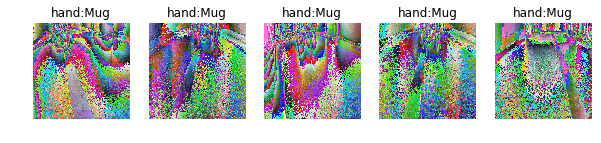

In [19]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    #image=preprocess(image).half()
    #image=color_isolation(image).half()
    index,prediction_prob = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(CATEGORIES[int(index)])+ ":" + str(CATEGORIES[int(labels[ii])]))
    plt.axis('off')
    plt.imshow(image)
    print(prediction_prob)
plt.show()


In [8]:
images.shape

torch.Size([5, 3, 224, 224])